In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import os
import tensorflow as tf
from pycocotools.coco import COCO

In [7]:
tfrecords = list(tf.python_io.tf_record_iterator(path="ms_coco_bbox_train.tfrecord"))
string_record = tfrecords[np.random.randint(0, len(tfrecords))]
example = tf.train.Example()
example.ParseFromString(string_record)
image_data = (example.features.feature["image/data"].bytes_list.value[0])
width = int(example.features.feature["image/width"].int64_list.value[0])
height = int(example.features.feature["image/height"].int64_list.value[0])
xmins = example.features.feature["bbox/xmin"].int64_list.value
ymins = example.features.feature["bbox/ymin"].int64_list.value
xmaxs = example.features.feature["bbox/xmax"].int64_list.value
ymaxs = example.features.feature["bbox/ymax"].int64_list.value
labels = example.features.feature["bbox/label"].int64_list.value
bboxes = zip(xmins, ymins, xmaxs, ymaxs)

image = np.fromstring(image_data, dtype=np.float32)
image = image.reshape((height, width, 3))

def plot_bboxes(image, bboxes, labels):
    fig, ax = plt.subplots(1, figsize=(8.0, 10.0))
    plt.imshow(image)

    rectangles = []
    color = []
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        rectangles.append(patches.Rectangle((xmin, ymin), xmax, ymax))
        color.append((np.random.random((1, 3))*0.6+0.4).tolist()[0])
        
        cat_name = coco.loadCats([label])[0]["name"]
        ax.text(xmin, ymin, cat_name, fontsize=12,
                horizontalalignment='left',
                verticalalignment='top',color="black",
                bbox={'facecolor':color[-1], "edgecolor": [x-0.25 for x in color[-1]], "linewidth": 2.0, 'alpha':0.75, 'pad':0})

    p = PatchCollection(rectangles, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(rectangles, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

    plt.show()
    
plot_bboxes(image, bboxes, labels)

KeyboardInterrupt: 

c:\anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


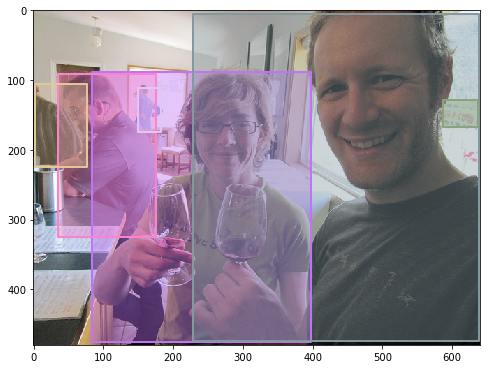

In [3]:
tfrecords = list(tf.python_io.tf_record_iterator(path="ms_coco_bbox_val.tfrecord"))
string_record = tfrecords[np.random.randint(0, len(tfrecords))]
example = tf.train.Example()
example.ParseFromString(string_record)
image_data = (example.features.feature["image/data"].bytes_list.value[0])
width = int(example.features.feature["image/width"].int64_list.value[0])
height = int(example.features.feature["image/height"].int64_list.value[0])
xmins = example.features.feature["bbox/xmin"].int64_list.value
ymins = example.features.feature["bbox/ymin"].int64_list.value
xmaxs = example.features.feature["bbox/xmax"].int64_list.value
ymaxs = example.features.feature["bbox/ymax"].int64_list.value
bboxes = zip(xmins, ymins, xmaxs, ymaxs)

image = np.fromstring(image_data, dtype=np.float32)
image = image.reshape((height, width, 3))

def plot_bboxes(image, bboxes):
    fig, ax = plt.subplots(1, figsize=(8.0, 10.0))
    plt.imshow(image)

    rectangles = []
    color = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        rectangles.append(patches.Rectangle((xmin, ymin), xmax, ymax))
        color.append((np.random.random((1, 3))*0.6+0.4).tolist()[0])

    p = PatchCollection(rectangles, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(rectangles, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

    plt.show()
    
plot_bboxes(image, bboxes)

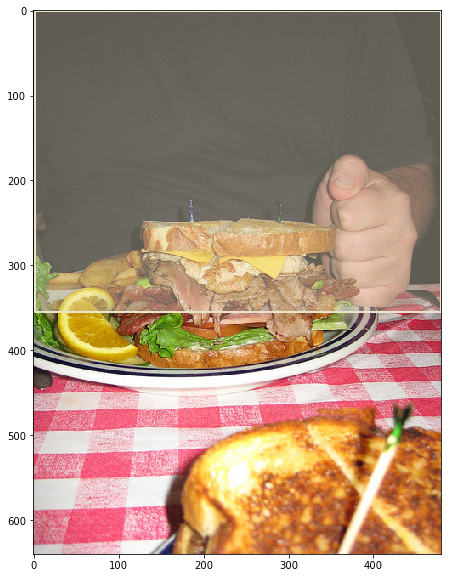

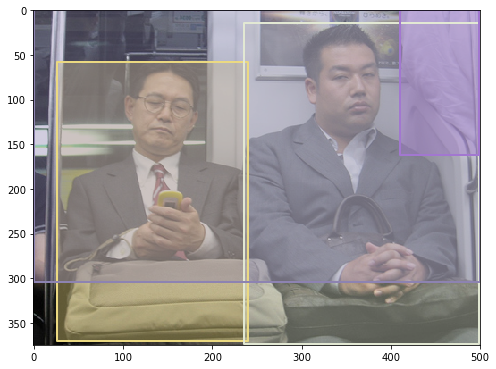

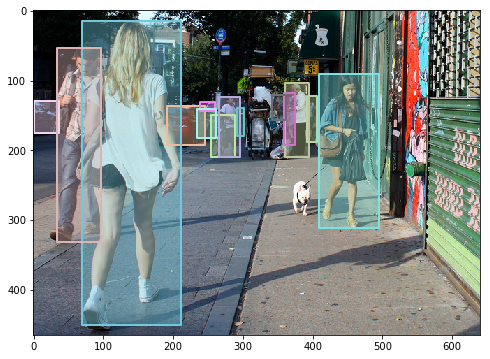

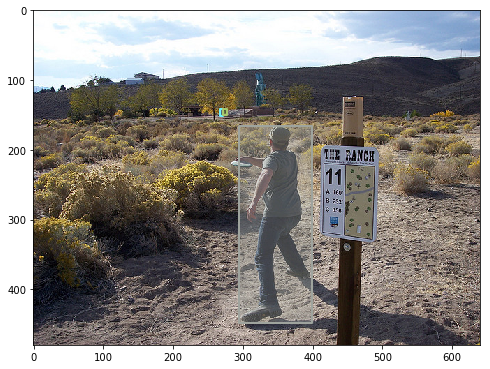

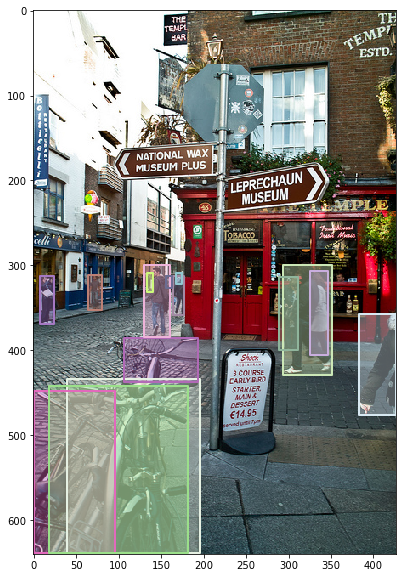

In [4]:
from dataset import get_dataset_size

def parse_record_fn(example_proto, is_training):
    feature_map = {
        "image/data":   tf.FixedLenFeature([], tf.string),
        "image/width":  tf.FixedLenFeature([], tf.int64),
        "image/height": tf.FixedLenFeature([], tf.int64),
        "bbox/xmin":    tf.VarLenFeature(tf.int64),
        "bbox/xmax":    tf.VarLenFeature(tf.int64),
        "bbox/ymin":    tf.VarLenFeature(tf.int64),
        "bbox/ymax":    tf.VarLenFeature(tf.int64)
    }
    features = tf.parse_single_example(example_proto, feature_map)
    
    height = tf.cast(features["image/height"], tf.int32)
    width = tf.cast(features["image/width"], tf.int32)
    
    image = tf.decode_raw(features["image/data"], tf.float32)
    image = tf.reshape(image, shape=(height, width, 3))
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)

    xmin = tf.expand_dims(features['bbox/xmin'].values, 0)
    ymin = tf.expand_dims(features['bbox/ymin'].values, 0)
    xmax = tf.expand_dims(features['bbox/xmax'].values, 0)
    ymax = tf.expand_dims(features['bbox/ymax'].values, 0)

    # Concat to make bbox
    bbox = tf.concat([xmin, ymin, xmax, ymax], 0)

    # Force the variable number of bounding boxes into the shape
    # [1, num_boxes, coords].
    bbox = tf.expand_dims(bbox, 0)
    bbox = tf.transpose(bbox, [0, 2, 1])
    
    return image, bbox

# Initialize TFRecordDataset from file
dataset = tf.data.TFRecordDataset(["ms_coco_bbox_train.tfrecord"])
dataset = dataset.prefetch(buffer_size=1)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.map(lambda value: parse_record_fn(value, True), num_parallel_calls=5)
dataset = dataset.batch(1)
dataset = dataset.prefetch(1)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    
    itr = dataset.make_one_shot_iterator()
    image, bbox = itr.get_next()
    #sess.run(itr.initializer)
    
    for i in range(5):#range(get_dataset_size("tiny_imagenet_1_train.tfrecord")):
        img, bb = sess.run([image, bbox])
           
        img = img[0,:,:,:]
        img -= np.min(img)
        img /= np.max(img)
        
        plot_bboxes(img, bb[0, 0])
    

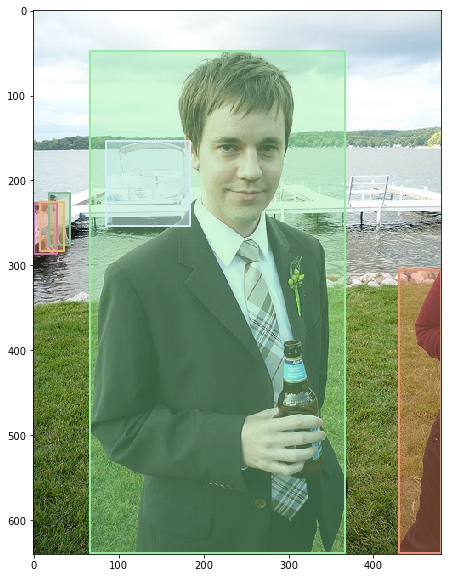

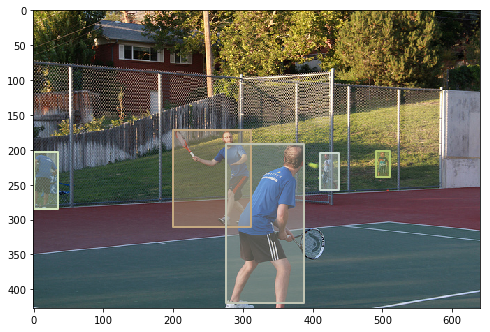

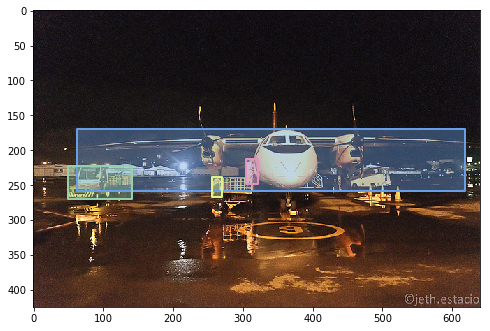

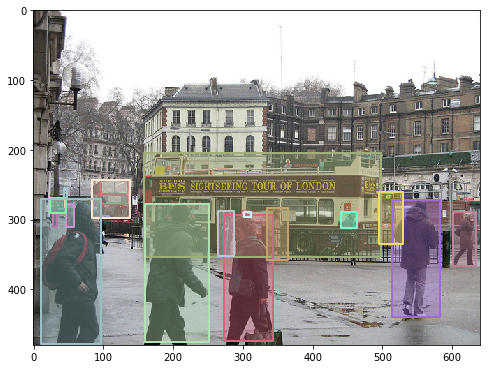

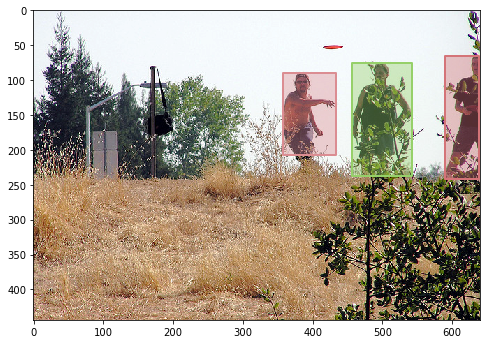

In [5]:
from dataset import get_dataset_size

def parse_record_fn(example_proto, is_training):
    feature_map = {
        "image/data":   tf.FixedLenFeature([], tf.string),
        "image/width":  tf.FixedLenFeature([], tf.int64),
        "image/height": tf.FixedLenFeature([], tf.int64),
        "bbox/xmin":    tf.VarLenFeature(tf.int64),
        "bbox/xmax":    tf.VarLenFeature(tf.int64),
        "bbox/ymin":    tf.VarLenFeature(tf.int64),
        "bbox/ymax":    tf.VarLenFeature(tf.int64)
    }
    features = tf.parse_single_example(example_proto, feature_map)
    
    height = tf.cast(features["image/height"], tf.int32)
    width = tf.cast(features["image/width"], tf.int32)
    
    image = tf.decode_raw(features["image/data"], tf.float32)
    image = tf.reshape(image, shape=(height, width, 3))
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)

    xmin = tf.expand_dims(features['bbox/xmin'].values, 0)
    ymin = tf.expand_dims(features['bbox/ymin'].values, 0)
    xmax = tf.expand_dims(features['bbox/xmax'].values, 0)
    ymax = tf.expand_dims(features['bbox/ymax'].values, 0)

    # Concat to make bbox
    bbox = tf.concat([xmin, ymin, xmax, ymax], 0)

    # Force the variable number of bounding boxes into the shape
    # [1, num_boxes, coords].
    bbox = tf.expand_dims(bbox, 0)
    bbox = tf.transpose(bbox, [0, 2, 1])
    
    return image, bbox

# Initialize TFRecordDataset from file
dataset = tf.data.TFRecordDataset(["ms_coco_bbox_val.tfrecord"])
dataset = dataset.prefetch(buffer_size=1)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.map(lambda value: parse_record_fn(value, True), num_parallel_calls=5)
dataset = dataset.batch(1)
dataset = dataset.prefetch(1)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    
    itr = dataset.make_one_shot_iterator()
    image, bbox = itr.get_next()
    #sess.run(itr.initializer)
    
    for i in range(5):#range(get_dataset_size("tiny_imagenet_1_train.tfrecord")):
        img, bb = sess.run([image, bbox])
           
        img = img[0,:,:,:]
        img -= np.min(img)
        img /= np.max(img)
        
        plot_bboxes(img, bb[0, 0])
    